In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

train_x_base = pd.read_csv("train_features.csv")
train_y = pd.read_csv("train_labels.csv")
test_x = pd.read_csv("test_features.csv")

classification_labels = [
    "LABEL_BaseExcess",
    "LABEL_Fibrinogen",
    "LABEL_AST",
    "LABEL_Alkalinephos",
    "LABEL_Bilirubin_total",
    "LABEL_Lactate",
    "LABEL_TroponinI",
    "LABEL_SaO2",
    "LABEL_Bilirubin_direct",
    "LABEL_EtCO2",
]
sepsis_label = "LABEL_Sepsis"
regression_labels = [
    "LABEL_RRate",
    "LABEL_ABPm",
    "LABEL_SpO2",
    "LABEL_Heartrate",
]

train_y.set_index("pid", inplace=True)
train_y.head()

,LABEL_BaseExcess,LABEL_Fibrinogen,LABEL_AST,LABEL_Alkalinephos,LABEL_Bilirubin_total,LABEL_Lactate,LABEL_TroponinI,LABEL_SaO2,LABEL_Bilirubin_direct,LABEL_EtCO2,LABEL_Sepsis,LABEL_RRate,LABEL_ABPm,LABEL_SpO2,LABEL_Heartrate
pid,,,,,,,,,,,,,,,
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,12.1,85.4,100.0,59.9
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.8,100.6,95.5,85.5
100,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,16.5,88.3,96.5,108.1
1000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,19.4,77.2,98.3,80.9
10000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.6,76.8,97.7,95.3


In [2]:
train_x_base.drop("Time", axis=1, inplace=True)
train_x = train_x_base.groupby("pid", sort=False)
train_x_age = train_x[["Age"]].mean()

train_x_base.drop("Age", axis=1, inplace=True)
train_x = train_x_base.groupby("pid", sort=False)

train_x = (
    train_x_age.join(train_x.mean(), rsuffix="_mean")
    .join(train_x.max(), rsuffix="_max")
    .join(train_x.min(), rsuffix="_min")
    .join(train_x.var(), rsuffix="_var")
    .join(train_x.count(), rsuffix="_count")
)
train_x.fillna(0, inplace=True)
train_x.head()

,Age,EtCO2,PTT,BUN,Lactate,Temp,Hgb,HCO3,BaseExcess,RRate,...,Alkalinephos_count,SpO2_count,Bilirubin_direct_count,Chloride_count,Hct_count,Heartrate_count,Bilirubin_total_count,TroponinI_count,ABPs_count,pH_count
pid,,,,,,,,,,,,,,,,,,,,,
1,34.0,0.000000,0.00,12.0,0.000,36.750000,8.566667,25.333333,-0.666667,17.000000,...,0,12,0,3,6,12,0,0,12,7
10,71.0,0.000000,27.80,12.0,0.000,36.000000,14.600000,0.000000,0.000000,18.090909,...,1,11,0,0,1,11,1,1,11,0
100,68.0,0.000000,20.90,21.0,0.000,36.250000,12.500000,27.000000,0.000000,14.833333,...,0,12,0,2,2,12,0,0,11,0
1000,79.0,31.863636,0.00,22.0,3.855,36.818182,9.200000,0.000000,0.000000,12.000000,...,0,11,0,0,1,11,0,0,11,1
10000,76.0,0.000000,28.55,22.0,0.000,36.750000,10.700000,25.500000,1.500000,12.090909,...,0,11,0,2,2,11,0,0,11,4


In [3]:
from sklearn.svm import LinearSVC, LinearSVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier, MultiOutputRegressor
from sklearn.model_selection import train_test_split

# from sklearn.impute import SimpleImputer

# N = 10000
N = len(train_x)
train_x_sample, train_y_sample = train_x.iloc[:N, :], train_y.iloc[:N, :]

X_train, X_test, y_train, y_test = train_test_split(
    train_x_sample, train_y_sample, test_size=0.33, random_state=42
)

model_reg = make_pipeline(
    StandardScaler(), LinearSVR(random_state=0, tol=1e-5)
)

model_clf = make_pipeline(
    StandardScaler(), LinearSVC(random_state=42, tol=1e-5)
)

reg = MultiOutputRegressor(model_reg).fit(X_train, y_train[regression_labels])
clf = MultiOutputClassifier(model_clf).fit(
    X_train, y_train[classification_labels + [sepsis_label]]
)

C:\Users\russo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\russo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\russo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\russo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\russo\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

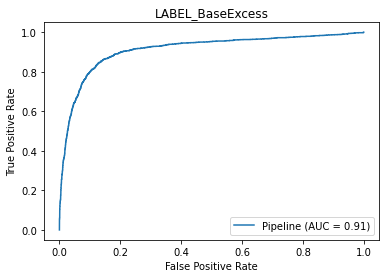

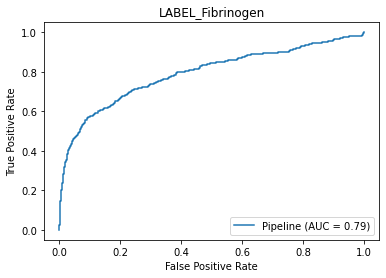

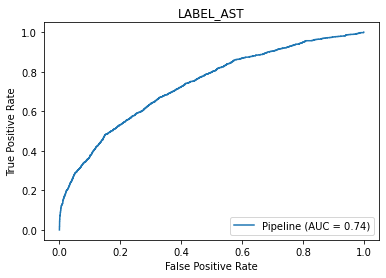

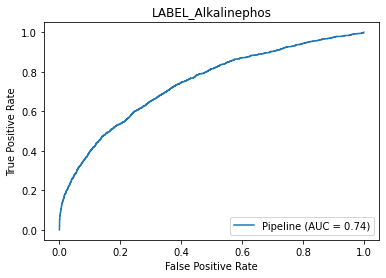

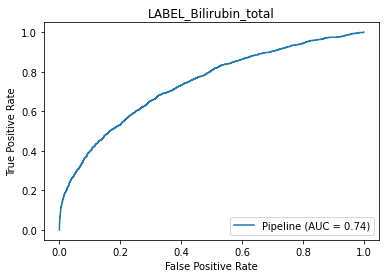

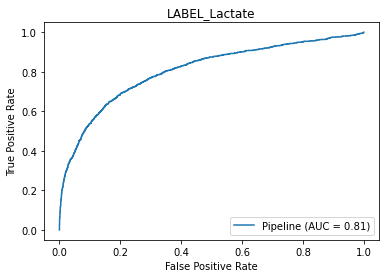

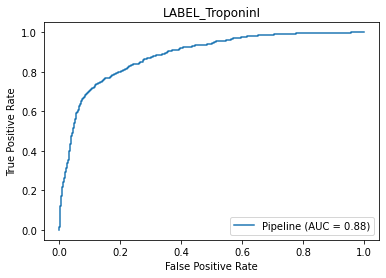

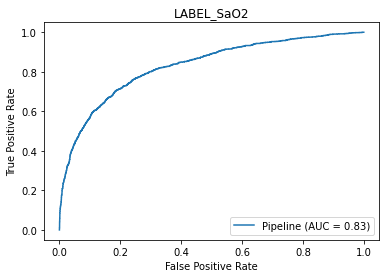

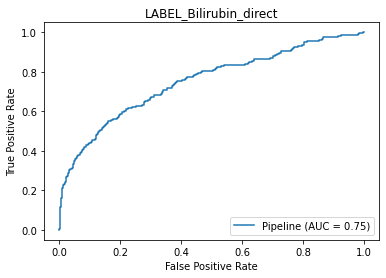

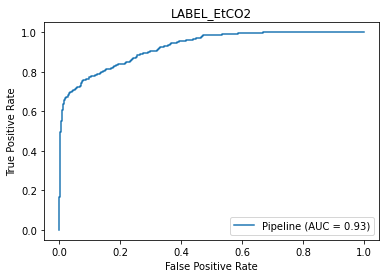

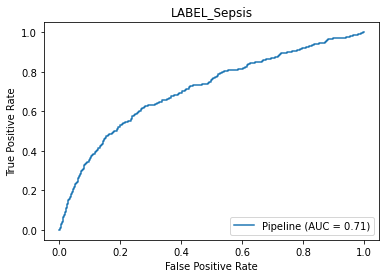

TASK 1: 0.8116823848296552
TASK 2: 0.709105505438616


In [23]:
from sklearn.metrics import roc_auc_score, plot_roc_curve

for idx, entry in enumerate(classification_labels + [sepsis_label]):
    g = plot_roc_curve(clf.estimators_[idx], X_test, y_test[entry])
    g.ax_.set_title(entry)
    plt.show()

task1 = np.mean(
    [
        roc_auc_score(
            y_test[entry], clf.estimators_[idx].decision_function(X_test)
        )
        for idx, entry in enumerate(classification_labels)
    ]
)
task2 = roc_auc_score(
    y_test[sepsis_label], clf.estimators_[-1].decision_function(X_test)
)
print("TASK 1:", task1)
print("TASK 2:", task2)

In [5]:
from sklearn.metrics import r2_score

task3 = np.mean(
    [
        0.5
        + 0.5
        * np.maximum(
            0, r2_score(y_test[entry], reg.estimators_[idx].predict(X_test))
        )
        for idx, entry in enumerate(regression_labels)
    ]
)
print("TASK 3:", task3)

TASK 3: 0.6846200748247904


In [6]:
print("FINAL SCORE", (task1 + task2 + task3) / 3)

FINAL SCORE 0.7351359883643539


In [30]:
X = pd.read_csv("test_features.csv")

# Preprocessing
X.drop("Time", axis=1, inplace=True)
X_grouped = X.groupby("pid", sort=False)
X_age = X_grouped[["Age"]].mean()

X.drop("Age", axis=1, inplace=True)
X_grouped = X.groupby("pid", sort=False)

X = (
    X_age.join(X_grouped.mean(), rsuffix="_mean")
    .join(X_grouped.max(), rsuffix="_max")
    .join(X_grouped.min(), rsuffix="_min")
    .join(X_grouped.var(), rsuffix="_var")
    .join(X_grouped.count(), rsuffix="_count")
)
X.fillna(0, inplace=True)
X.head()

,Age,EtCO2,PTT,BUN,Lactate,Temp,Hgb,HCO3,BaseExcess,RRate,...,Alkalinephos_count,SpO2_count,Bilirubin_direct_count,Chloride_count,Hct_count,Heartrate_count,Bilirubin_total_count,TroponinI_count,ABPs_count,pH_count
pid,,,,,,,,,,,,,,,,,,,,,
0,39.0,0.0,41.35,18.5,0.00,36.000000,9.65,14.5,-6.5,11.714286,...,2,9,0,2,2,8,2,0,8,2
10001,62.0,0.0,0.00,0.0,0.00,37.250000,0.00,0.0,0.0,16.666667,...,0,10,0,0,0,10,0,0,9,0
10003,72.0,0.0,0.00,0.0,2.01,36.909091,0.00,0.0,0.0,16.818182,...,0,11,0,0,0,11,0,0,11,2
10004,44.0,0.0,0.00,10.0,0.00,36.250000,12.70,0.0,0.0,13.857143,...,1,11,0,0,1,11,1,0,11,0
10005,88.0,0.0,39.90,42.0,0.00,36.000000,8.80,25.0,0.0,19.272727,...,0,11,0,1,1,11,0,0,10,0


In [34]:
reg_df = pd.DataFrame(
    index=X.index, columns=regression_labels, data=reg.predict(X)
)
clf_df = pd.DataFrame(
    index=X.index,
    columns=classification_labels,
    data=np.array(
        [
            clf.estimators_[idx].decision_function(X)
            for idx, entry in enumerate(classification_labels)
        ]
    ).T,
)
clf_df[sepsis_label] = clf.estimators_[-1].decision_function(X)

pd.concat([reg_df, clf_df], axis=1).to_csv(
    "submission.rar", float_format="%.3f", compression="zip"
)